In [0]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FINAL-TF2-FILES/TF_2_Notebooks_and_Data/DATA/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [0]:
df.columns = ['Sales']

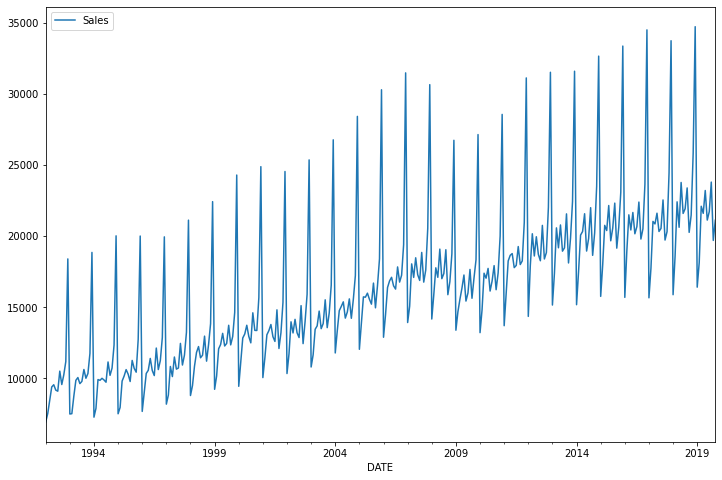

In [7]:
df.plot(figsize=(12,8))

In [8]:
len(df)

334

In [9]:
len(df)- 18

316

In [0]:
test_size = 12

In [0]:
test_ind = len(df)- test_size

In [0]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [13]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381


In [14]:
test

,Sales
DATE,
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410
2019-02-01,18134
2019-03-01,22093
2019-04-01,21597
2019-05-01,23200
2019-06-01,21123
2019-07-01,21714


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [17]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=2)

In [0]:
# What does the first batch look like?
X,y = generator[0]

In [22]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266
 0.02127505 0.05580163 0.08942056 0.09512053 0.08146965 0.07860151
 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266 0.02047633]
Predict this y: 
 [[0.02047633]
 [0.02127505]]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [0]:
# We're only using one feature in our time series
n_features = 1

In [37]:
# define model
neuron_performance = []
for n in range (1,251):
  n_neurons = n
  model = Sequential()
  model.add(LSTM(n_neurons, activation='relu', input_shape=(length, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit_generator(generator,epochs=6,
                      validation_data=validation_generator,
                      callbacks=early_stop)
  test_predictions = []

  first_eval_batch = scaled_train[-length:]
  current_batch = first_eval_batch.reshape((1, length, n_features))

  for i in range(len(test)):
    
      # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
      current_pred = model.predict(current_batch)[0]
    
      # store prediction
      test_predictions.append(current_pred) 
    
      # update batch to now include prediction and drop first value
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
  true_predictions = scaler.inverse_transform(test_predictions)
  try: 
    test = test.drop('Predictions',axis=1)
    test['Predictions'] = true_predictions
  except:
    test['Predictions'] = true_predictions
  performance = np.sqrt(mean_squared_error(test["Sales"],test["Predictions"]))
  neuron_performance.append(performance)

Epoch 1/6
155/155 [==============================] - 1s 5ms/step - loss: 0.1128 - val_loss: 0.1516
Epoch 2/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0651 - val_loss: 0.0918
Epoch 3/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0455 - val_loss: 0.0605
Epoch 4/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0385 - val_loss: 0.0441
Epoch 5/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0363 - val_loss: 0.0366
Epoch 6/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0358 - val_loss: 0.0336
Epoch 1/6
155/155 [==============================] - 1s 5ms/step - loss: 0.1130 - val_loss: 0.1535
Epoch 2/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0656 - val_loss: 0.0923
Epoch 3/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0455 - val_loss: 0.0599
Epoch 4/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0384 - val_loss: 0.0443
Epoch 5/6


In [0]:
nn = pd.DataFrame(neuron_performance)

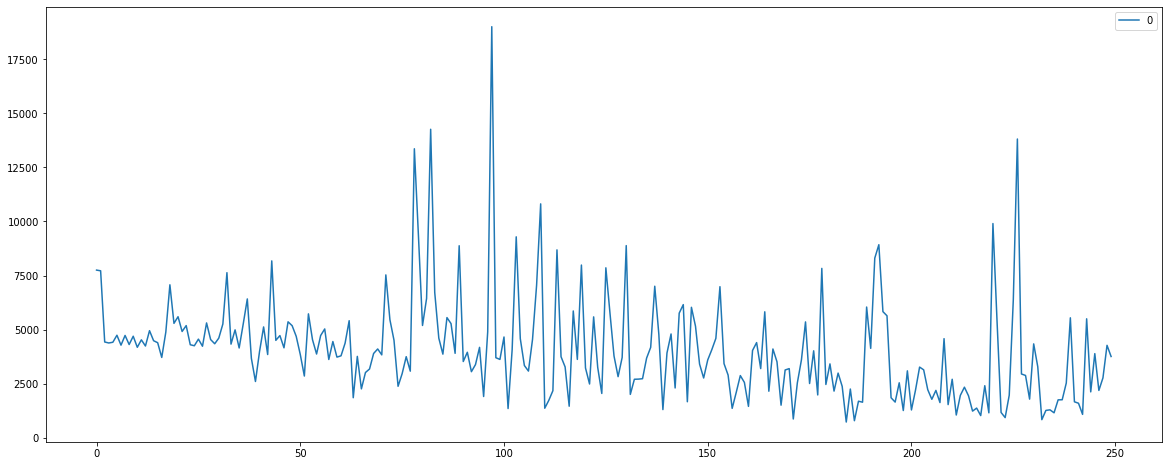

In [39]:
nn.plot(figsize=(20,8))

In [40]:
model.summary()

Model: "sequential_508"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_508 (LSTM)              (None, 250)               252000    
_________________________________________________________________
dense_508 (Dense)            (None, 1)                 251       
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [0]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length-1, batch_size=2)

In [78]:
# fit model
model = Sequential()
model.add(LSTM(n_neurons, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=5,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/5
161/161 [==============================] - 3s 19ms/step - loss: 0.0247 - val_loss: 0.0953
Epoch 2/5
161/161 [==============================] - 3s 18ms/step - loss: 0.0221 - val_loss: 0.0177
Epoch 3/5
161/161 [==============================] - 3s 18ms/step - loss: 0.0143 - val_loss: 0.0932


In [0]:

losses = pd.DataFrame(model.history.history)

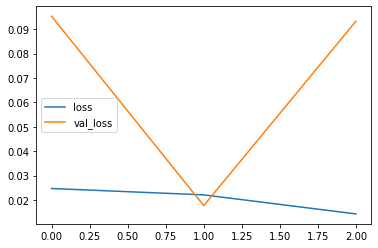

In [80]:
losses.plot()

In [0]:
n_input = 12

In [0]:
first_eval_batch = scaled_train[-length:]

In [0]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [84]:
model.predict(first_eval_batch)

array([[0.84055644]], dtype=float32)

In [85]:
scaled_test[0]

array([0.68592071])

In [0]:
import numpy as np
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [0]:
true_predictions = scaler.inverse_transform(test_predictions)

In [0]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [89]:
test

,Sales,Predictions
DATE,,
2018-11-01,25831,30090.286659
2018-12-01,34706,32320.811350
2019-01-01,16410,24131.640828
2019-02-01,18134,26204.621516
2019-03-01,22093,28133.627266
2019-04-01,21597,28118.459135
2019-05-01,23200,29837.090997
2019-06-01,21123,29399.177079
2019-07-01,21714,30259.721860


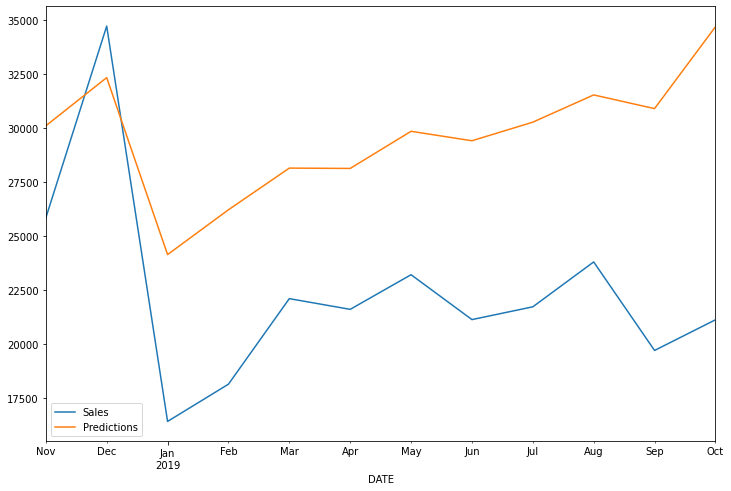

In [90]:
test.plot(figsize=(12,8))

In [0]:
from sklearn.metrics import mean_squared_error

In [65]:
np.sqrt(mean_squared_error(test["Sales"],test["Predictions"]))

3584.082864323302

In [0]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [0]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=2)

In [68]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
161/161 [==============================] - 2s 10ms/step - loss: 0.0267
Epoch 2/8
161/161 [==============================] - 2s 9ms/step - loss: 0.0207
Epoch 3/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0174
Epoch 4/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0144
Epoch 5/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0064
Epoch 6/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0054
Epoch 7/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 8/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0015


In [0]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [0]:
forecast = scaler.inverse_transform(forecast)

In [71]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [0]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [0]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [74]:
forecast_df

,Forecast
2019-11-01,26280.353817
2019-12-01,34913.826307
2020-01-01,18173.747740
2020-02-01,19554.299702
2020-03-01,22832.331703
2020-04-01,22435.323637
2020-05-01,23794.921118
2020-06-01,22074.245276
2020-07-01,22588.825651
2020-08-01,24352.825642


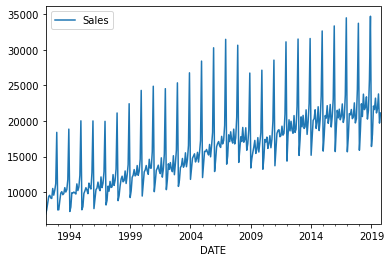

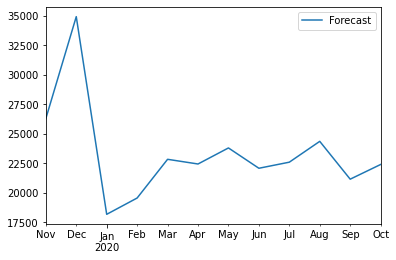

In [75]:
df.plot()
forecast_df.plot()

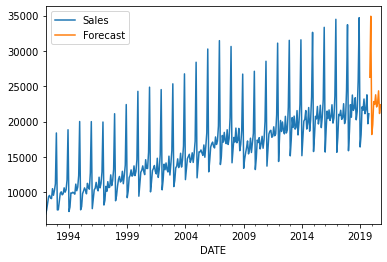

In [76]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

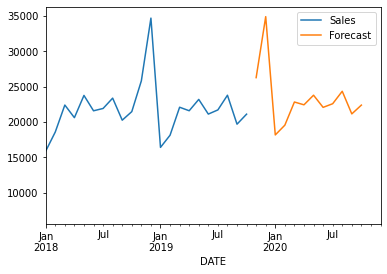

In [77]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')